100%|██████████| 100000/100000 [00:27<00:00, 3617.94it/s]


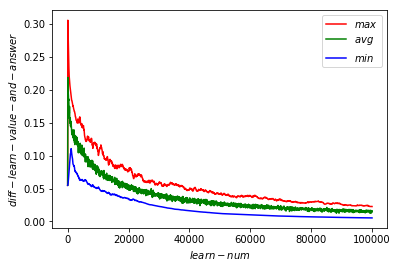

inputs:  [[ 1.]
 [ 0.]]
answer:  [[0.0], [1.0]]
[[ 0.11485623]
 [ 0.96987922]]


In [31]:
% matplotlib inline

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

def get_answer(answer_mode, inputs, node_num):
    """Get input value of correct answer derived from input value
    param: answer_mode (integer): 
    param: inputs (ndarray): input values
    return (integer): 0 or 1
    """
    result = []
    if answer_mode == 1:
        # 1input&2output
        result = [
            [inputs[0][0]], 
            [0.0 if (inputs[1][0] == 1.0) else 1.0]
        ]
    elif answer_mode == 2:
        # 2input&2output
        result = [
            [0.0 if (inputs[inputs == 0.0].size) else 1.0],
            [1.0 if (inputs[inputs == 1.0].size) else 0.0]
        ]
    elif answer_mode == 3:
        # xor
        answer_matrix = np.array([
            [0., 0., 0., 0.],
            [0., 1., 0., 1.],
            [1., 0., 0., 1.],
            [1., 1., 1., 0.],
        ])
        for i in answer_matrix:
            if i[0] == inputs[0][0] and i[1] == inputs[1][0]:
                result = np.array([
                    [i[2]], [i[3]]
                ])

    return result

class Layer():
    """Learning 'logical and' layer
    """

    def __init__(self, node_num, input_num):
        """init
        param: node_num (integer): node num
        param: input_num (integer): input number
        param: output_num (integer): output number
        """
        self._node_num = node_num
        self._input_num = input_num
#         self._output_num = output_num

        # Learning rate
        self._rate = 0.01
        # weight to input values default
        self._weight = np.random.rand(self._node_num, input_num)
        # bias value
        self._bias = np.zeros((self._node_num, 1))
        # output values
        self._output = None

        self.diff = None

    def forward(self, inputs):
        """forward　process
        """
        # calculate the state by input values(inputs) and weight(_weight) and(_bias)
        state = self._weight.dot(inputs) + self._bias
        # calculate output value
        self._output = self._activation_func(state)

    def _activation_func(self, state):
        """Activation function
        """
        # calculate the output value by the state of neuron(0~1)
        # logistic sigmoid
        return 1 / (1 + np.exp(-state))

    def backward(self, weight):
        """backward　process(feedback)
        param: inputs (ndarray): input values
        return (float): Difference between output value and correct answer value after learning
        """
        one_arr = np.empty((0,(self._node_num - 1)), int)
        for i in range(0, self._node_num):
            one_arr = np.append(one_arr, np.array([[1.]]), axis=0)

        if weight is None:
            self.diff = self.diff * (self._output * (one_arr - self._output))
        else:
            self.diff = weight.dot(self.diff) * (self._output * (one_arr - self._output))

    def update(self, inputs, d_cost_func):

        # derivative value of activate function
        one_arr = np.empty((0,(self._node_num - 1)), int)
        for i in range(0, self._node_num):
            one_arr = np.append(one_arr, np.array([[1.]]), axis=0)
        d_activate_func = self._output * (one_arr - self._output)
        # common coefficient
        common_coefficient = d_cost_func * d_activate_func

        # update weight
        self._weight -= self._rate * common_coefficient * inputs
        # update bias
        self._bias -= self._rate * common_coefficient


if __name__ == '__main__':

    """
    1: 1input&2output
    2: 2input&2output
    3: xor
    """
    answer_mode = 2
    # layner num
    layer_num = 2
    # node num
    node_num = 2
    # input num
    input_num = 2
    # learn loop num
    learn_num = 100000
    # result output interval
    interval = 50

    layers = []
    for layer_no in range(0, layer_num):
        layers.append(Layer(2, input_num))

    output_x = []
    tmp_y = []
    output_y_max = []
    output_y_avg = []
    output_y_min = []
    d_cost_func = None
    for i in tqdm(range(0, learn_num)):

        # inputs
        x = np.round(np.random.rand(input_num, 1))

        # forward process
        answer = get_answer(answer_mode, x, node_num)

        for layer_no in range(0, len(layers)):
            layers[layer_no].forward(x)
            # for graph
            if layer_no == 0:
                tmp_diff = layers[layer_no]._output - answer

        output_diff = (np.power(tmp_diff[0][0], 2) / 2) + (np.power(tmp_diff[1][0], 2) / 2)

        # backward process
        for layer_no in range(len(layers) - 1, -1, -1):
            next_weight = None
            # set diff
            layers[layer_no].diff = layers[layer_no]._output - answer
            if layer_no != len(layers) - 1:
                # 初回ではない
                next_weight = layers[layer_no]._weight
            layers[layer_no].backward(next_weight)

        # update
        for layer_no in range(0, len(layers)):
            d_cost_func = layers[layer_no]._output - answer
            layers[layer_no].update(x, d_cost_func)

        tmp_y.append(output_diff)
        if i % interval == 0:
            # Average, max, min value for each set number of loops
            output_y_max.append(max(tmp_y))
            output_y_avg.append(sum(tmp_y) / len(tmp_y))
            output_y_min.append(min(tmp_y))
            tmp_y = []
            output_x.append(i+1)

    line_max, line_avg, line_min = plt.plot(
        output_x, output_y_max, 'r-', 
        output_x, output_y_avg, 'g-', 
        output_x, output_y_min, 'b-'
    )
    plt.legend((line_max, line_avg, line_min), ('$max$', '$avg$', '$min$'))
    plt.xlabel('$learn-num$')
    plt.ylabel('$diff-learn-value-and-answer$')
    plt.show()


    """
    x = np.round(np.random.rand(input_num, 1))
    answer = get_answer(answer_mode, x, node_num)
    for layer_no in range(0, len(layers)):
        layers[layer_no].forward(x)
        if layer_no == 0:
            tmp_diff = layers[layer_no]._output - answer
    print("inputs: ", x)
    print("answer: ", answer)
    print(layers[layer_no]._output)
    """